In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load Data

In [2]:
scaler = StandardScaler()

In [3]:
X_train = scaler.fit_transform(np.loadtxt('X_train_feature1.csv', delimiter=','))

In [4]:
X_up_test = scaler.transform(np.loadtxt('X_up_test_feature1.csv', delimiter=','))
X_down_test = scaler.transform(np.loadtxt('X_down_test_feature1.csv', delimiter=','))
X_updown_test = scaler.transform(np.loadtxt('X_updown_test_feature1.csv', delimiter=','))
y_train = np.loadtxt('y_train_label1.csv', delimiter=',')
y_up_test = np.loadtxt('y_up_test_label1.csv', delimiter=',')
y_down_test = np.loadtxt('y_down_test_label1.csv', delimiter=',')
y_updown_test = np.loadtxt('y_updown_test_label1.csv', delimiter=',')

## Downsampling training

In [5]:
BUY = 0
HOLD = 1
SELL = 2

(array([ 1903.,     0.,     0.,     0.,     0., 48603.,     0.,     0.,
            0.,  1903.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

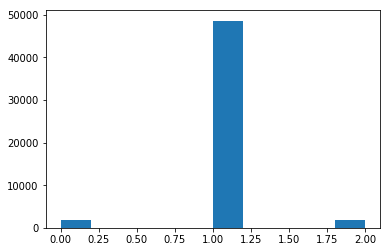

In [6]:
plt.hist(y_train)

num of buy = num of sell

In [7]:
len(np.where(y_train == BUY)[0]) - len(np.where(y_train == SELL)[0])

0

In [8]:
buysell_idx = np.append(np.where(y_train == BUY)[0], np.where(y_train == SELL)[0])

In [9]:
sample = len(np.where(y_train == BUY)[0])

In [10]:
sample_idx = np.where(y_train == HOLD)[0][np.random.permutation(sample)]

In [11]:
equal_idx = np.append(buysell_idx, sample_idx)

In [12]:
X_train = X_train[equal_idx]

In [13]:
y_train = y_train[equal_idx]

(array([1903.,    0.,    0.,    0.,    0., 1903.,    0.,    0.,    0.,
        1903.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

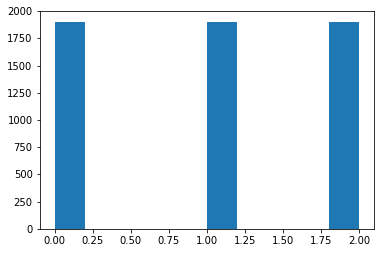

In [14]:
plt.hist(y_train)

# Machine Learning Models

In [15]:
from sklearn.metrics import classification_report

In [30]:
def sklearn_experiment(clf, name='model'):
    %matplotlib inline
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    print('training')
    print(classification_report(y_train, y_pred_train, target_names=['buy', 'hold', 'sell']))
    plt.figure(figsize=(7,4))
    plt.title('actual training')
    plt.hist(y_train)
    plt.figure(figsize=(7,4))
    plt.title('predicted training')
    plt.hist(y_pred_train)
    np.savetxt('{}_pred_train.csv'.format(name), y_pred_train, delimiter=',')
    
    print('\n\n\ntesting on up data')
    y_pred_test = clf.predict(X_up_test)
    print(classification_report(y_up_test, y_pred_test, target_names=['buy', 'hold', 'sell']))
    plt.figure(figsize=(7,4))
    plt.title('actual test')
    plt.hist(y_up_test)
    plt.figure(figsize=(7,4))
    plt.title('predicted test')
    plt.hist(y_pred_test)
    np.savetxt('{}_pred_up.csv'.format(name), y_pred_test, delimiter=',')
    
    print('\n\n\ntesting on down data')
    y_pred_test = clf.predict(X_down_test)
    print(classification_report(y_down_test, y_pred_test, target_names=['buy', 'hold', 'sell']))
    plt.figure(figsize=(7,4))
    plt.title('actual test')
    plt.hist(y_up_test)
    plt.figure(figsize=(7,4))
    plt.title('predicted test')
    plt.hist(y_pred_test)
    np.savetxt('{}_pred_down.csv'.format(name), y_pred_test, delimiter=',')
    
    print('\n\n\ntesting on updown data')
    y_pred_test = clf.predict(X_updown_test)
    print(classification_report(y_updown_test, y_pred_test, target_names=['buy', 'hold', 'sell']))
    plt.figure(figsize=(7,4))
    plt.title('actual test')
    plt.hist(y_up_test)
    plt.figure(figsize=(7,4))
    plt.title('predicted test')
    plt.hist(y_pred_test)
    np.savetxt('{}_pred_updown.csv'.format(name), y_pred_test, delimiter=',')
    
    return clf

## Generalized Linear Models

In [31]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

training
              precision    recall  f1-score   support

         buy       0.46      0.37      0.41      1903
        hold       0.36      0.60      0.45      1903
        sell       0.41      0.22      0.28      1903

   micro avg       0.40      0.40      0.40      5709
   macro avg       0.41      0.40      0.38      5709
weighted avg       0.41      0.40      0.38      5709




testing on up data
              precision    recall  f1-score   support

         buy       0.07      0.01      0.01      1021
        hold       0.89      0.99      0.94     15577
        sell       0.03      0.00      0.00       963

   micro avg       0.88      0.88      0.88     17561
   macro avg       0.33      0.33      0.32     17561
weighted avg       0.79      0.88      0.83     17561




testing on down data
              precision    recall  f1-score   support

         buy       0.17      0.00      0.00      2002
        hold       0.76      1.00      0.86     12898
        sell       0

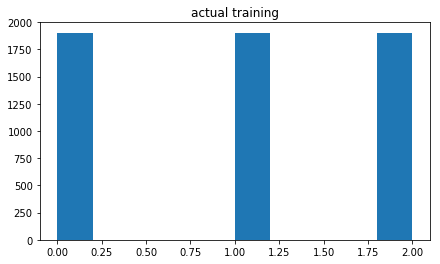

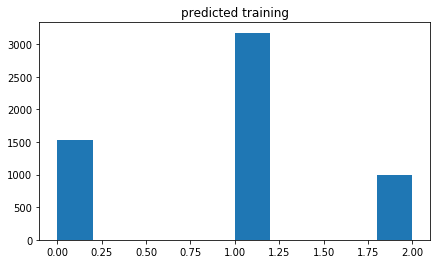

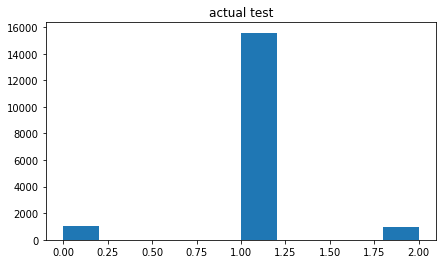

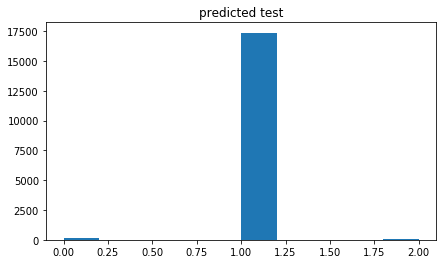

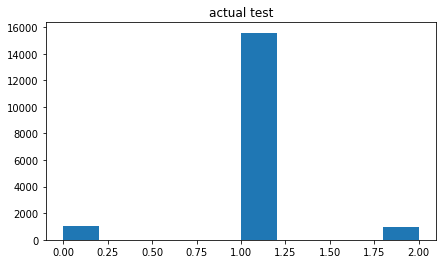

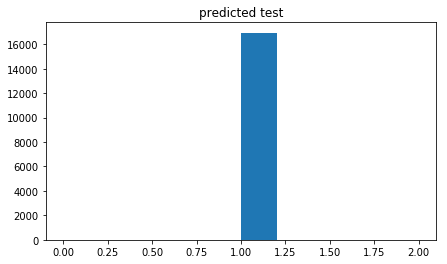

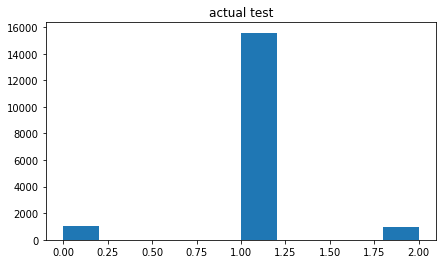

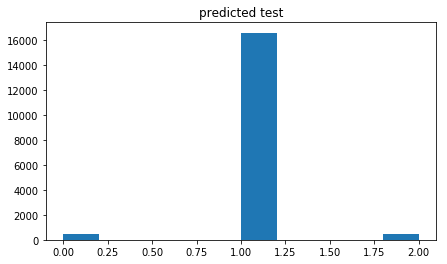

In [32]:
clf = sklearn_experiment(LogisticRegression(solver='lbfgs', max_iter=200, multi_class='multinomial'), name='logreg')

training
              precision    recall  f1-score   support

         buy       0.38      0.73      0.50      1903
        hold       0.45      0.01      0.03      1903
        sell       0.39      0.42      0.40      1903

   micro avg       0.39      0.39      0.39      5709
   macro avg       0.41      0.39      0.31      5709
weighted avg       0.41      0.39      0.31      5709




testing on up data
              precision    recall  f1-score   support

         buy       0.06      0.03      0.04      1021
        hold       0.97      0.00      0.01     15577
        sell       0.06      0.99      0.11       963

   micro avg       0.06      0.06      0.06     17561
   macro avg       0.36      0.34      0.05     17561
weighted avg       0.87      0.06      0.02     17561




testing on down data
              precision    recall  f1-score   support

         buy       0.11      0.00      0.01      2002
        hold       1.00      0.00      0.00     12898
        sell       0

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

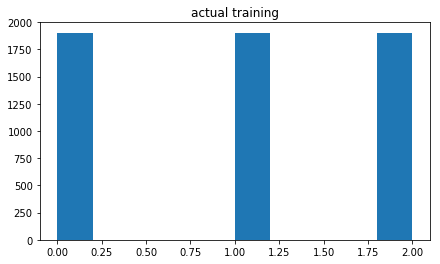

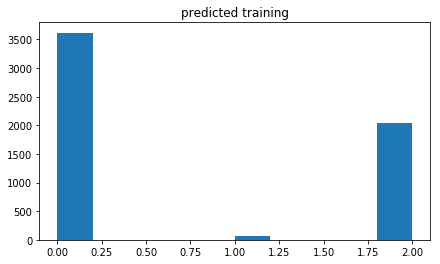

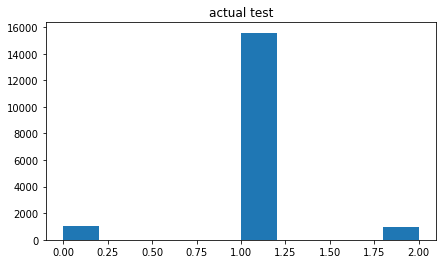

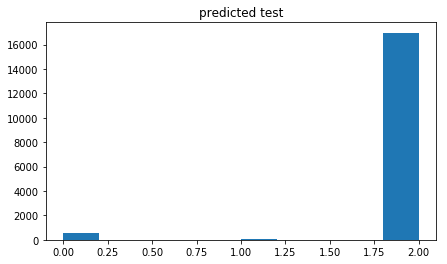

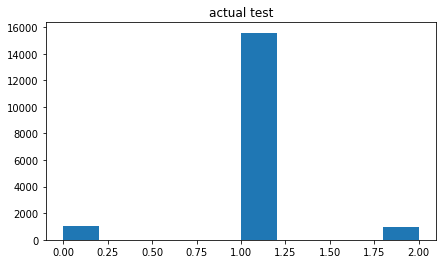

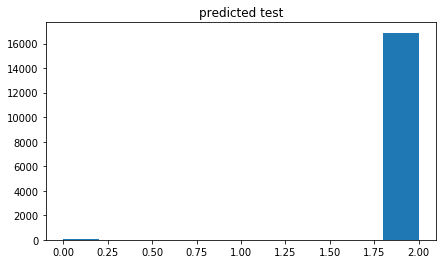

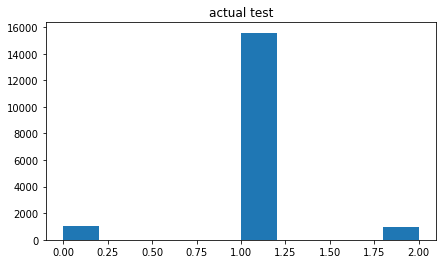

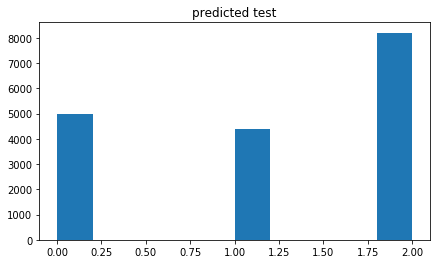

In [33]:
sklearn_experiment(SGDClassifier(max_iter=1000, tol=1e-3), name='sgd')

## Ensemble Models

In [35]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

training
              precision    recall  f1-score   support

         buy       1.00      1.00      1.00      1903
        hold       1.00      1.00      1.00      1903
        sell       1.00      1.00      1.00      1903

   micro avg       1.00      1.00      1.00      5709
   macro avg       1.00      1.00      1.00      5709
weighted avg       1.00      1.00      1.00      5709




testing on up data
              precision    recall  f1-score   support

         buy       0.07      0.36      0.12      1021
        hold       0.87      0.31      0.46     15577
        sell       0.05      0.36      0.09       963

   micro avg       0.32      0.32      0.32     17561
   macro avg       0.33      0.34      0.22     17561
weighted avg       0.78      0.32      0.42     17561




testing on down data
              precision    recall  f1-score   support

         buy       0.14      0.40      0.21      2002
        hold       0.74      0.32      0.44     12898
        sell       0

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

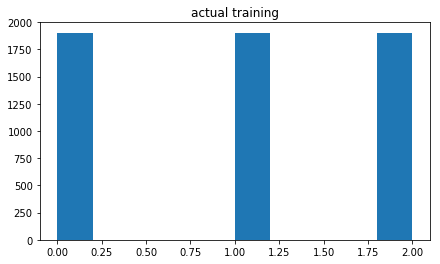

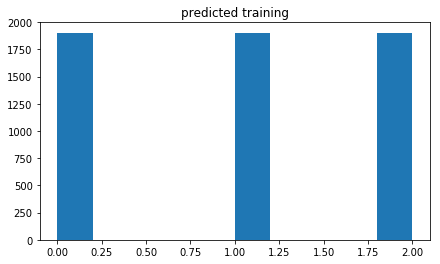

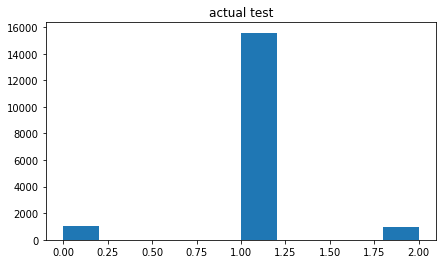

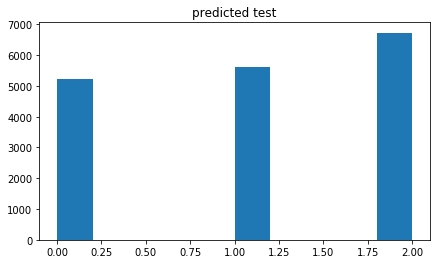

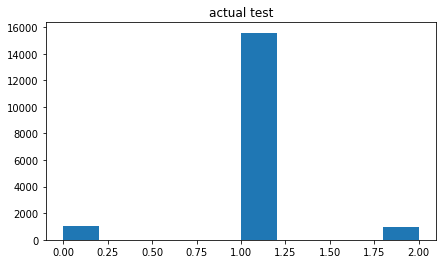

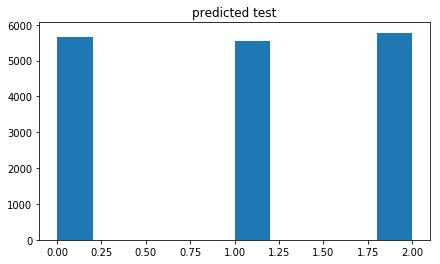

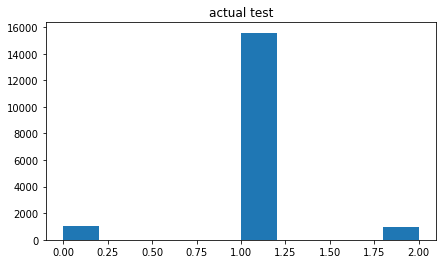

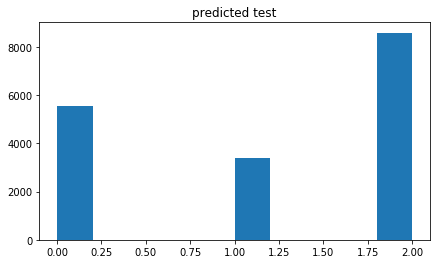

In [36]:
sklearn_experiment(RandomForestClassifier(n_estimators=200), name='randomforest')

training
              precision    recall  f1-score   support

         buy       0.55      0.58      0.56      1903
        hold       0.50      0.49      0.50      1903
        sell       0.51      0.50      0.50      1903

   micro avg       0.52      0.52      0.52      5709
   macro avg       0.52      0.52      0.52      5709
weighted avg       0.52      0.52      0.52      5709




testing on up data
              precision    recall  f1-score   support

         buy       0.04      0.12      0.06      1021
        hold       0.91      0.30      0.45     15577
        sell       0.07      0.65      0.12       963

   micro avg       0.31      0.31      0.31     17561
   macro avg       0.34      0.35      0.21     17561
weighted avg       0.81      0.31      0.41     17561




testing on down data
              precision    recall  f1-score   support

         buy       0.07      0.04      0.05      2002
        hold       0.86      0.10      0.18     12898
        sell       0

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=250, random_state=None)

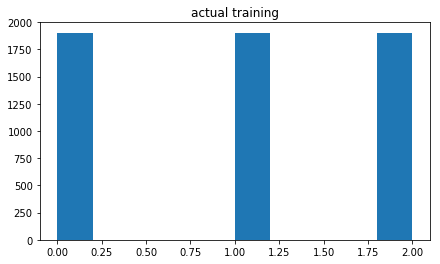

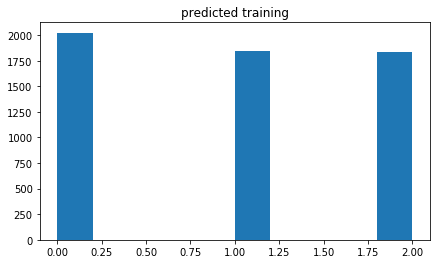

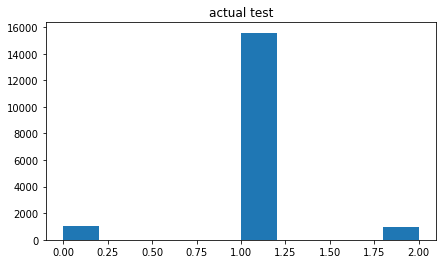

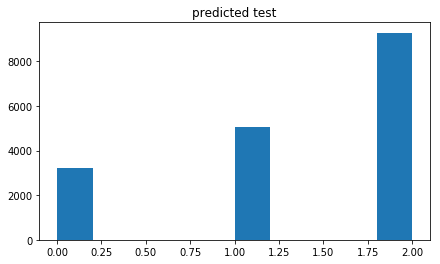

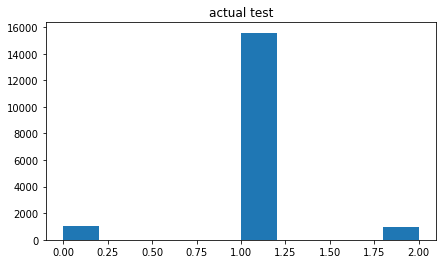

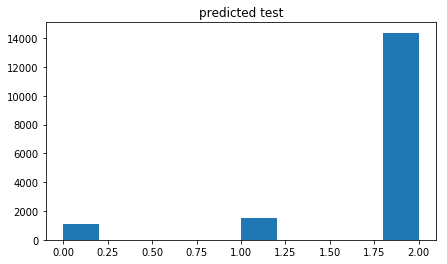

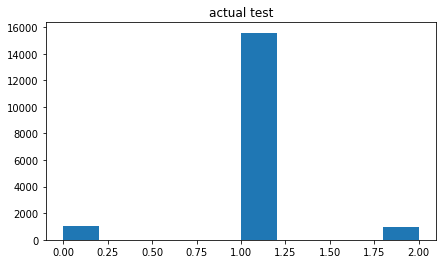

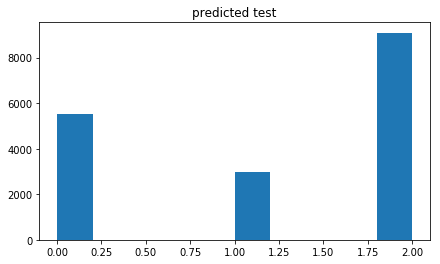

In [37]:
sklearn_experiment(AdaBoostClassifier(n_estimators=250), name='ada')

training
              precision    recall  f1-score   support

         buy       0.69      0.69      0.69      1903
        hold       0.69      0.68      0.68      1903
        sell       0.68      0.69      0.68      1903

   micro avg       0.68      0.68      0.68      5709
   macro avg       0.68      0.68      0.68      5709
weighted avg       0.68      0.68      0.68      5709




testing on up data
              precision    recall  f1-score   support

         buy       0.07      0.80      0.13      1021
        hold       0.94      0.09      0.17     15577
        sell       0.05      0.21      0.08       963

   micro avg       0.14      0.14      0.14     17561
   macro avg       0.35      0.37      0.12     17561
weighted avg       0.84      0.14      0.16     17561




testing on down data
              precision    recall  f1-score   support

         buy       0.13      0.94      0.22      2002
        hold       0.87      0.01      0.01     12898
        sell       0

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=350,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

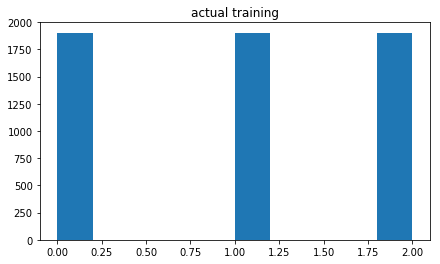

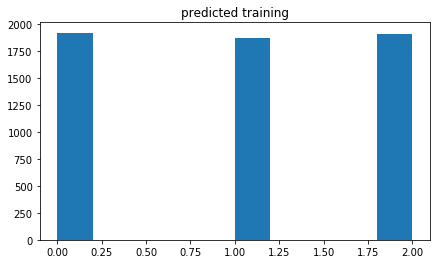

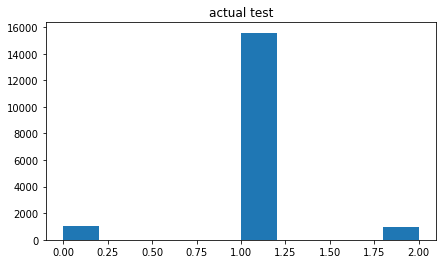

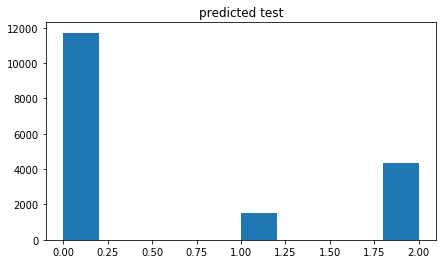

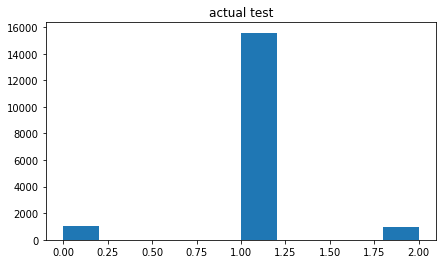

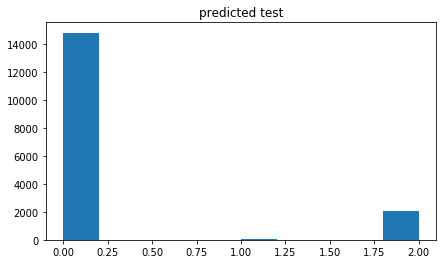

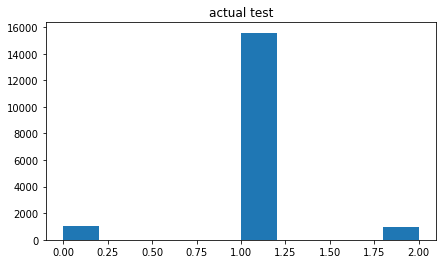

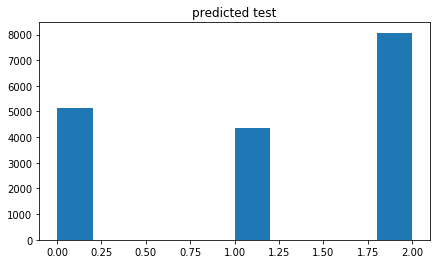

In [38]:
sklearn_experiment(GradientBoostingClassifier(n_estimators=350), name='gboost')

# Predict when to buy first.. 

In [76]:
X_train_buy_nobuy = X_train[np.where(y_train != 2)]
y_train_buy_nobuy = y_train[np.where(y_train != 2)]
X_up_test_buy_nobuy = X_up_test[np.where(y_up_test != 2)]
y_up_test_buy_nobuy = y_up_test[np.where(y_up_test != 2)]

In [135]:
clf = GradientBoostingClassifier(n_estimators=1000)

In [136]:
clf.fit(X_train_buy_nobuy, y_train_buy_nobuy)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [137]:
print(classification_report(
    y_train_buy_nobuy, clf.predict(X_train_buy_nobuy), target_names=['buy', 'don\'t']
))

              precision    recall  f1-score   support

         buy       0.90      0.96      0.93      1904
       don't       0.96      0.90      0.93      1904

   micro avg       0.93      0.93      0.93      3808
   macro avg       0.93      0.93      0.93      3808
weighted avg       0.93      0.93      0.93      3808



In [138]:
print(classification_report(
    y_up_test_buy_nobuy, clf.predict(X_up_test_buy_nobuy), target_names=['buy', 'don\'t']
))

              precision    recall  f1-score   support

         buy       0.08      0.54      0.14      1020
       don't       0.95      0.61      0.75     15577

   micro avg       0.61      0.61      0.61     16597
   macro avg       0.52      0.58      0.45     16597
weighted avg       0.90      0.61      0.71     16597

